In [1]:
cypher = """
MATCH path = (bp:BioProc{prefName:"Brassinosteroid Mediated Signaling Pathway"})
      <- [part:participates_in] - (rprotein:Protein)
      -  [xr:h_s_s|xref|ortho*0..1] - (protein:Protein)
      <-  [enc:enc] - (gene:Gene)
      - [occ:occ_in] -> (pub:Publication)
WHERE toFloat ( occ.TFIDF ) > 20
RETURN DISTINCT gene, toFloat ( occ.TFIDF ) AS score, pub
ORDER BY score DESC, pub.identifier
LIMIT 50
"""

Let's run the against the Neo4j endpoint:

In [2]:
from neo4j import GraphDatabase
#driver = GraphDatabase.driver( "bolt://babvs65.rothamsted.ac.uk:7688", auth = ( "rouser", "rouser" ) )
driver = GraphDatabase.driver( "bolt://www.marcobrandizi.info:7687" )
session = driver.session()
result = session.run( cypher )


Another nice tabular visualisation:

In [3]:
import pandas as pd
dframe = []
for record in result:
    gene = record [ "gene" ]
    pub = record [ "pub" ]
    score = record [ "score" ]
    dframe.append ( [ pub[ "identifier" ], pub[ "AbstractHeader" ], \
                     gene[ "prefName" ], gene [ "identifier" ], score ] )
dframe = pd.DataFrame ( dframe, \
                       columns = [ "PMID", "Title", "Gene Symbol", "Gene Acc", "Score" ] )
display ( dframe )

,PMID,Title,Gene Symbol,Gene Acc,Score
0,28710392,Comparative study of Arabidopsis PBS1 and a wh...,PBS1,TRAESCS2D02G284200,50.095543
1,28710392,Comparative study of Arabidopsis PBS1 and a wh...,PBS1,TRAESCS2B02G302800,50.095543
2,28710392,Comparative study of Arabidopsis PBS1 and a wh...,PBS1,TRAESCS2A02G285700,50.095543
3,16222089,"Cloning, characterization and expression of wh...",EDR1,TRAESCS1A02G131600,38.629639
4,16222089,"Cloning, characterization and expression of wh...",EDR1,TRAESCS1D02G136400,38.629639
5,16222089,"Cloning, characterization and expression of wh...",EDR1,TRAESCS4B02G276200,38.629639
6,16222089,"Cloning, characterization and expression of wh...",EDR1,TRAESCS4A02G029800,38.629639
7,16222089,"Cloning, characterization and expression of wh...",EDR1,TRAESCS1B02G154400,38.629639
8,16222089,"Cloning, characterization and expression of wh...",EDR1,TRAESCS4D02G274400,38.629639
9,24073880,Mycosphaerella graminicola LysM effector-media...,CERK1,TRAESCS7D02G265400,36.804436


And a quick graph of gene/publication sets:

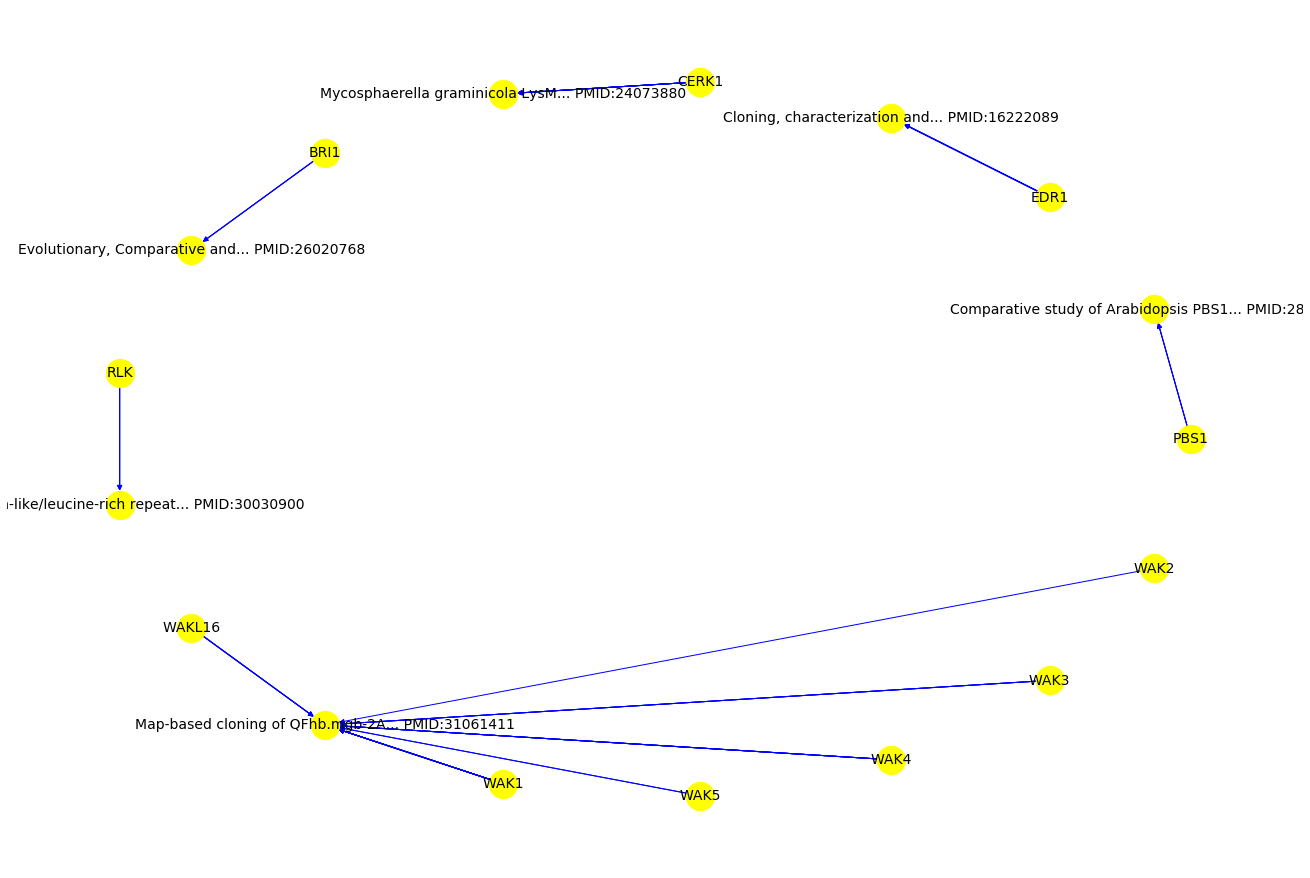

In [4]:
%matplotlib inline
import warnings
import networkx as nx
import matplotlib.pyplot as plt
import textwrap as tw

warnings.filterwarnings('ignore')

figsz = plt.gcf().get_size_inches()
plt.gcf().set_size_inches ( figsz * 3 ) 

g = nx.MultiDiGraph()
result = session.run( cypher ) # It's a consumable stream, you need to regenerate it
for record in result:
    gene = record [ "gene" ]
    gid = gene [ "prefName" ] #+ ":" + gene [ "identifier" ]

    pub = record [ "pub" ]
    pid = pub [ "AbstractHeader" ]
    pid = tw.shorten ( pid, width = 40, fix_sentence_endings = True, placeholder = '...' ) \
        + " " + pub [ "prefName" ]
    #pid = pub [ "prefName" ]

    g.add_node ( gid )
    g.add_node ( pid )
    g.add_edge ( gid, pid )

# kamada_kawai_layout
nx.draw (g, pos = nx.circular_layout ( g ), \
         with_labels = True, node_color = 'yellow', node_size = 800, \
         edge_color = 'blue', font_size = 14 )
plt.show()
